In [1]:
struct ZeroSizeVector{T} <: AbstractVector{T}
    n :: Int
    f
end

function Base.size(A :: ZeroSizeVector{T}) where T
    return (A.n, )
end

function Base.getindex(A :: ZeroSizeVector{T}, I) where T
    if i < 1 || i > A.n
        throw(BoundsError(A, i))
    end
    
    return A.f(i)
end

In [2]:
struct Vector2dView{T} <: AbstractVector{T}
    n :: Int
    m :: Int
    v :: AbstractVector{T}
end

function Base.size(A :: Vector2dView{T}) where T
    return (A.n, A.m)
end

function Base.getindex(A :: Vector2dView{T}, i) where T    
    if i < 1 || i > A.n
        throw(BoundsError(A, i))
    end
    
    return @view A.v[(i-1)*A.m+1:i*A.m]
end

In [3]:
v = [1, 1, 1, 2, 2, 2]
mv = Vector2dView(2, 3, v)

2×3 Vector2dView{Int64}:
 [1, 1, 1]
 [2, 2, 2]

  1.195511 seconds (9.44 M allocations: 513.601 MiB, 6.65% gc time, 9.30% compilation time)


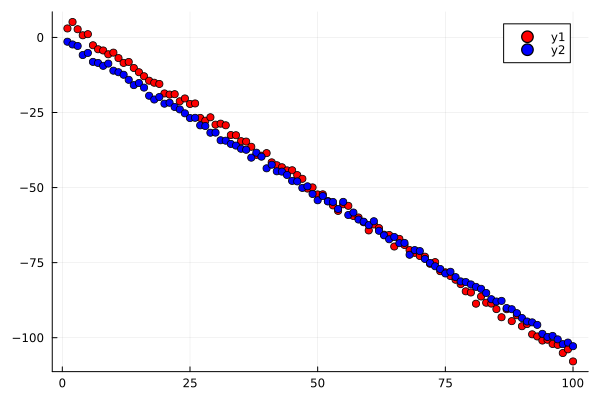

In [60]:
using Random
using Gen
using Plots
using Flux.Optimise
using GenFluxOptimizers

Random.seed!(1)

"""
Rezumat VI:
- avem un "true mode" necunoscut care ne-a generat datele (reviews filme, interactiuni, fenomene fizie)
- creem un model care sa spuna povestea generativa a modelului adevarat
- creen un model variational care depinde doar de variabilele latente ale modului nostru

folosim VI ca sa fituim parametri modelului variational, apoi vom folosi parametri inferati in modelul nostru generativ
"""

# Modelul "real", necunoscut, va genera observatiile
@gen function true_model(xs)
    slope = @trace(normal(-1, exp(0.5)), :slope)
    intercept = @trace(normal(1, exp(2.0)), :intercept)
    
    ys = []
    for (i, x) in enumerate(xs)
        push!(ys, @trace(normal(slope * x + intercept, 1), :y => i))
    end
    return ys
end

true_data = true_model(1:100)

# Povestea generativa, incercam sa reproducem modelul real, nu cunoastem parametri reali
@gen function my_model(xs, a=-1, b=0.5, c=1, d=2.0)
    slope = @trace(normal(a, exp(b)), :slope)
    intercept = @trace(normal(c, exp(d)), :intercept)
    
    ys = []
    for (i, x) in enumerate(xs)
        push!(ys, @trace(normal(slope * x + intercept, 1), :y => i))
    end
    return ys
end

# Model pentru aproximarea variabilelor latente
@gen function approx()
    @param slope_mu::Float64
    @param slope_log_std::Float64
    @param intercept_mu::Float64
    @param intercept_log_std::Float64
    
    @trace(normal(slope_mu, exp(slope_log_std)), :slope)
    @trace(normal(intercept_mu, exp(intercept_log_std)), :intercept)
end


# Constrangierile vor fi observatiile generate de modelul real
observations = choicemap()
for i in 1:100
    observations[:y => i] = true_data[i]
end

# Initializam parametrii modelului aproximativ la ceva, orice
init_param!(approx, :slope_mu, 0.)
init_param!(approx, :slope_log_std, 0.)
init_param!(approx, :intercept_mu, 0.)
init_param!(approx, :intercept_log_std, 0.)

# Gradient descent pentru parametri 
update = ParamUpdate(GradientDescent(1e-6, 1000), approx)
#optimizer = FluxOptimConf(Optimise.Descent, (1e-6,))
#update = ParamUpdate(optimizer, approx)
# update = ParamUpdate(Gen.ADAM(0.1, 0.9, 0.999, 1), approx)

# Folosim VI ca sa fituim parametrii modelului aproximativ la valorile adevarate a variabilelor latente
elbo_estimate, traces, elbo_history = @time black_box_vi!(my_model, (1:100, ), observations, approx, (), update;
    iters=100, samples_per_iter=100, verbose=false)


# Dupa fit luam rezultatele
slope_mu = get_param(approx, :slope_mu)
slope_log_std = get_param(approx, :slope_log_std)
intercept_mu = get_param(approx, :intercept_mu)
intercept_log_std = get_param(approx, :intercept_log_std)

# Bagam rezultatele inferate in modlul nostru si comparam cu datele reale 
my_data = my_model(1:100, slope_mu, slope_log_std, intercept_mu, intercept_log_std)
plot(1:100, [true_data, my_data], color=[:red :blue], seriestype=:scatter)

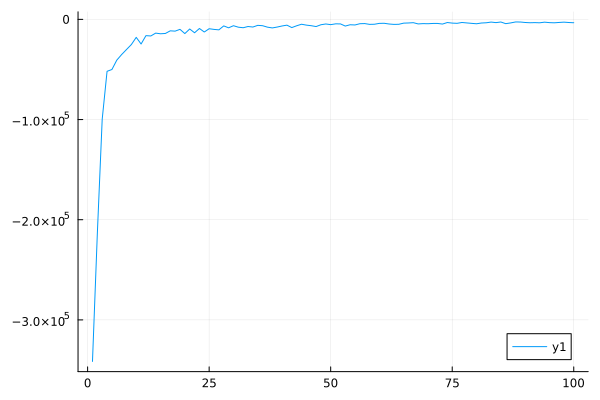

In [56]:
plot(1:length(elbo_history), elbo_history)

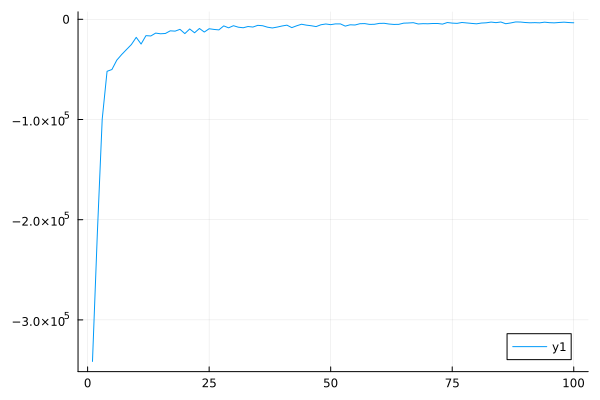

In [58]:
plot(1:length(elbo_history), elbo_history)

In [7]:
eps()

2.220446049250313e-16